<a href="https://colab.research.google.com/github/RusAl84/IntroML/blob/master/2_10_%D0%92%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BD%D1%8B%D0%B5_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D1%82%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Векторные представления изображений
Как мы убедились, информация, содержащаяся в промежуточных слоях хорошо обученных нейронных сетей, достаточна для классификации изображений. Это значит, что мы можем заменить изображение этой информацией и работать с ней. Например, с предпоследнего слоя получается некоторый вектор, значит можем исходное изображение представить (описать) этим вектором.

Получили векторное представление изображения. Эти вектора не банальны, их достаточно, чтобы классифицировать изображения, значит в них установлены какие-то важные взаимосвязи между пикселями изображения.

А давайте такие вектора кластеризуем. Не окажется ли так, что они группируются в "похожие" группы. Для кластеризации и уменьшения размерности можно воспользоваться методами главных компонент PCA и T-SNE, давайте с их помощью отобразим вектора изображений в двумерное пространство.

![img](https://drive.google.com/uc?id=19U3gdTfOYzZBbTiqdmEwU0PEOmfHn-rh)

Возьмем уже обученную сеть (здесь ResNet50).

Пропустим через нее изображение. И возвратим вектор, который получается перед классификатором (здесь выход с полносвязного слоя после слоя flatten, стрелка на рис.). Будем дальше работать с этими векторами.

Все эти операции уже реализованы в библиотеке [img2vec-keras](https://github.com/jaredwinick/img2vec-keras), установим ее.

Для сравнения векторов лучше подходит "косинусное расстояние" - косинус угла между ними, чем больше, тем похожей.  




Установим библиотеку и, если потребуется, после установки нажмите "Restart Runtime".

In [ ]:
!pip install git+https://github.com/jaredwinick/img2vec-keras.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jaredwinick/img2vec-keras.git to /tmp/pip-req-build-f3gqgpro
  Running command git clone -q https://github.com/jaredwinick/img2vec-keras.git /tmp/pip-req-build-f3gqgpro
  Created wheel for img2vec-keras: filename=img2vec_keras-0.2-py3-none-any.whl size=6216 sha256=32fe6e598fac376067c2f846889d58cf50fe1a64af55cb2b1fc858c7c1aeeeb4
  Stored in directory: /tmp/pip-ephem-wheel-cache-cp98aqse/wheels/6a/8e/87/5a04076e0aecd09365628be939f68e062922be436fd5945c79
Successfully built img2vec-keras


In [ ]:
import gdown # модуль для загрузки с гугл-диска
url = 'https://drive.google.com/uc?id=1Madin3qXe3Xexox5qOhASGulFR2wvsFz' # адрес
output = '101_ObjectCategories.tar.gz' # название загружаемого файла
gdown.download(url, output, quiet=False) # загружаем
!echo "Downloading 101_Object_Categories for image notebooks"
# распаковываем
!tar -xzf 101_ObjectCategories.tar.gz
# удаляем после распаковки
!rm 101_ObjectCategories.tar.gz
!ls
root = '101_ObjectCategories' # директория с файлами

Downloading...
From: https://drive.google.com/uc?id=1Madin3qXe3Xexox5qOhASGulFR2wvsFz
To: /content/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 82.3MB/s]


101_ObjectCategories  sample_data


In [ ]:
from img2vec_keras import Img2Vec # подключаем библиотеку для векторных представлений

from IPython.display import Image

import glob # для работы с файлами

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity # похожесть по косинусному расстоянию.
from sklearn.decomposition import PCA # метод клавных компонент
from sklearn.manifold import TSNE # метод TSNE
from sklearn.preprocessing import StandardScaler # масштабирование, убирает среднее, единичный разброс.

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import cv2

In [ ]:
img2vec = Img2Vec() # инициализируем вектора, загрузится предобученная сеть.

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
image_paths = []
image_classes = ['pizza', 'schooner', 'scissors', 'panda', 'brain'] # выберем классы для отображения, проверьте с другими

# считываем пути к изображениям этих классов
for image_class in image_classes:
  image_paths.extend(glob.glob('101_ObjectCategories/' + image_class + '/*.jpg')) # только .jpg

In [ ]:
# сколько их
len(image_paths)

291

In [ ]:
# создаем вектора для этих изображений
image_vectors = {}
for image_path in image_paths: # для каждого файла
  vector = img2vec.get_vec(image_path) # получаем векторное представление
  image_vectors[image_path] = vector # добавляем в словарь, название=ключ.

In [ ]:
# массив только с векторами, размер вектора 2048
X = np.stack(list(image_vectors.values()))

In [ ]:
pca_50 = PCA(n_components=50) #  первые 50 главных компонент
pca_result_50 = pca_50.fit_transform(X) # и проецируем на них
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
print(np.shape(pca_result_50))

# 2 компоненты  TSNE
tsne = TSNE(n_components=2, verbose=1, n_iter=3000)
tsne_result = tsne.fit_transform(pca_result_50) # проецируем

Cumulative explained variation for 50 principal components: 0.765102207660675
(291, 50)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 291 samples in 0.000s...
[t-SNE] Computed neighbors for 291 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 291 / 291
[t-SNE] Mean sigma: 12.771752


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.488136
[t-SNE] KL divergence after 1250 iterations: 0.355619


In [ ]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result) # масштабируем

Читаем изображения. Порядок такой же как при создании векторов, ведь как вы помните, TSNE работает только с теми векторами на которых и обучался, с другими не может.

In [ ]:
# читаем изображения
images = []
for image_path in image_paths:
  image = cv2.imread(image_path, 3) # загружаем изображение
  b,g,r = cv2.split(image)           # разделяем каналы b, g, r
  image = cv2.merge([r,g,b])         # собираем в r, g, b
  image = cv2.resize(image, (50,50)) # масштаб
  images.append(image)        # добавляем в список



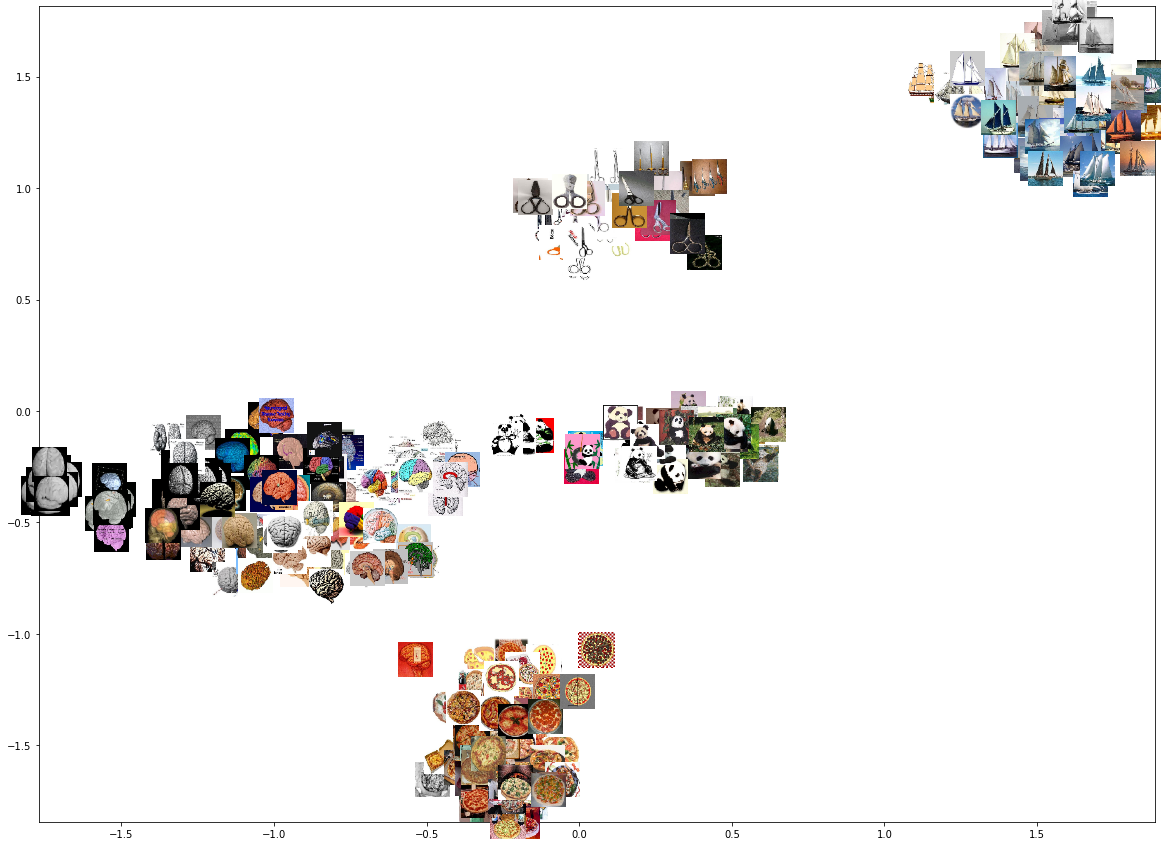

In [ ]:
# рисуем
fig, ax = plt.subplots(figsize=(20,15))
artists = []

for xy, i in zip(tsne_result_scaled, images): # перебираем TSNE вектора (это двумерные координаты) и изображения
  x0, y0 = xy # разделяем горизонтальную и вертикальную координату
  img = OffsetImage(i, zoom=.7) # задаем графический объект с картинкой
  ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False) # вставляем эту картинку по координатам из вектора TSNE
  artists.append(ax.add_artist(ab)) # добавляем на график
ax.update_datalim(tsne_result_scaled) # пределы отображения
ax.autoscale(enable=True, axis='both', tight=True) # автомасштаб
plt.show() # отображаем

И действительно, видим, что похожие изображения собрались в группы. Установили, что у "похожих" изображений "похожие" вектора.

Векторное представление это очень мощный инструмент обработки изображений, теперь мы можем работать с векторами вместо самих изображений. Найти похожие изображения? Нет проблем, сравните их вектора по косинусному расстоянию.

In [ ]:
# путь к первому изображению
image_path1='101_ObjectCategories/Leopards/image_0001.jpg'
# его вектор, должен быть размером 1на2048
vector1 = np.reshape(img2vec.get_vec(image_path1),(1,-1))

# путь ко второму изображению
image_path2='101_ObjectCategories/Motorbikes/image_0001.jpg'
# его вектор, должен быть размером 1на2048
vector2 = np.reshape(img2vec.get_vec(image_path2),(1,-1))

# их похожесть, чем больше тем похожей
similarity_matrix = cosine_similarity(vector1, vector2)

print('для разных ',similarity_matrix[0][0])

# путь к третьему изображению
image_path3='101_ObjectCategories/Motorbikes/image_0005.jpg'
# его вектор, должен быть размером 1на2048
vector3 = np.reshape(img2vec.get_vec(image_path3),(1,-1))

# их похожесть, чем больше тем похожей
similarity_matrix = cosine_similarity(vector3, vector2)

print('для похожих ',similarity_matrix[0][0])

для разных  0.25445843
для похожих  0.901036


# Ссылки
Использованы и адаптированы материалы:


https://github.com/jaredwinick/img2vec-keras

